# **Logistics Vehicle Maintenance Recommendation Using Classification Model**

1. **Final Project RMT 045 – Group 01**
- Data Analyst : Rivaldi Revin
- Data Scientist : Hafiz Alfariz
- Data Scientist : I Gusti Ngurah Bagus Dwira Palguna
- Data Engineer : Fhad Saleh

2. **Latar Belakang**

Perawatan kendaraan merupakan aspek krusial dalam operasional logistik, karena kegagalan teknis tidak hanya berdampak pada keselamatan pengemudi, tetapi juga pada keterlambatan distribusi dan meningkatnya biaya operasional. Data dari National Highway Traffic Safety Administration (NHTSA) menunjukkan bahwa sekitar 20% kecelakaan kendaraan disebabkan oleh pemeliharaan yang buruk, seperti ban aus, tekanan ban tidak sesuai, atau rem yang tidak berfungsi optimal. Selain itu, studi dari Federal Motor Carrier Safety Administration (FMCSA) menemukan bahwa operator dengan catatan pemeliharaan yang buruk memiliki risiko kecelakaan 65% lebih tinggi dibandingkan rata-rata nasional. Fakta ini menegaskan bahwa pemeliharaan kendaraan tidak hanya menjadi tanggung jawab teknis, tetapi juga menyangkut aspek keselamatan dan efisiensi logistik.

Dalam menghadapi tantangan tersebut, pemanfaatan machine learning dengan dukungan data Internet of Things (IoT) menjadi solusi potensial. Dataset yang berisi informasi detail tentang kondisi kendaraan—seperti jam operasional, konsumsi bahan bakar, suhu mesin, getaran, kondisi ban dan rem, hingga riwayat perawatan—dapat dianalisis untuk memprediksi kebutuhan pemeliharaan (Maintenance_Required). Model prediktif ini diharapkan mampu mengurangi risiko kegagalan teknis, menekan biaya perbaikan, serta meningkatkan efisiensi rantai pasok dengan perawatan yang lebih terjadwal dan tepat sasaran.

3. **Tujuan**

Pengembangan model prediktif ini diharapkan mampu:
* Mengurangi risiko kecelakaan dengan mengidentifikasi kendaraan yang berpotensi mengalami kegagalan teknis.
* Menekan biaya operasional dengan perawatan yang lebih terjadwal dan tepat sasaran.
* Meningkatkan efisiensi distribusi melalui pengurangan downtime dan keterlambatan pengiriman.
* Mendukung keputusan berbasis data dalam strategi perawatan armada kendaraan logistik.

4. **Dataset**

- Sumber : https://www.kaggle.com/datasets/datasetengineer/logistics-vehicle-maintenance-history-dataset
- Deskripsi : Dataset terdiri dari 92,000 records tentang vehicle maintenance predictions dari logistics operations di seluruh California.

# Library

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import inspect
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTENC
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import joblib

# Data loading

In [4]:
df = pd.read_csv('logistics_dataset_with_maintenance_required.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92000 entries, 0 to 91999
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Vehicle_ID             92000 non-null  int64  
 1   Make_and_Model         92000 non-null  object 
 2   Year_of_Manufacture    92000 non-null  int64  
 3   Vehicle_Type           92000 non-null  object 
 4   Usage_Hours            92000 non-null  int64  
 5   Route_Info             92000 non-null  object 
 6   Load_Capacity          92000 non-null  float64
 7   Actual_Load            92000 non-null  float64
 8   Last_Maintenance_Date  92000 non-null  object 
 9   Maintenance_Type       92000 non-null  object 
 10  Maintenance_Cost       92000 non-null  float64
 11  Engine_Temperature     92000 non-null  float64
 12  Tire_Pressure          92000 non-null  float64
 13  Fuel_Consumption       92000 non-null  float64
 14  Battery_Status         92000 non-null  float64
 15  Vi

In [6]:
# Check the balance of target
print(df['Maintenance_Required'].value_counts())

Maintenance_Required
1    70655
0    21345
Name: count, dtype: int64


In [7]:
# Initial check missing value, unique value, and cardinality
col_name = []
col_type = []
col_null = []
col_nunique = []
col_unique = []

for col in df.columns:
  col_name.append(col)
  col_type.append(df[col].dtype)
  col_null.append(df[col].isnull().sum())
  col_nunique.append(df[col].nunique())
  col_unique.append(df[col].unique())

tab_info = pd.DataFrame({
    'col_name':col_name,
    'col_type':col_type,
    'col_null':col_null,
    'col_nunique':col_nunique,
    'col_unique':col_unique
    })

tab_info

,col_name,col_type,col_null,col_nunique,col_unique
0,Vehicle_ID,int64,0,92000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,Make_and_Model,object,0,4,"[Ford F-150, Volvo FH, Chevy Silverado, Tesla ..."
2,Year_of_Manufacture,int64,0,18,"[2022, 2015, 2011, 2014, 2007, 2021, 2020, 201..."
3,Vehicle_Type,object,0,2,"[Truck, Van]"
4,Usage_Hours,int64,0,11975,"[530, 10679, 4181, 2974, 2539, 2319, 2440, 677..."
5,Route_Info,object,0,3,"[Rural, Urban, Highway]"
6,Load_Capacity,float64,0,92000,"[7.534548889487573, 7.671728261172365, 2.90115..."
7,Actual_Load,float64,0,92000,"[9.004246504178607, 6.111785185847196, 3.00605..."
8,Last_Maintenance_Date,object,0,547,"[2023-04-09, 2023-07-20, 2023-03-17, 2024-05-0..."
9,Maintenance_Type,object,0,3,"[Oil Change, Tire Rotation, Engine Overhaul]"


# Exploratory Data Analysis

In [8]:
# Create function for Visualization
# Define function for scatterplot
def create_single_scatterplot(df, x_col, y_col, hue_col):
    """
    Create scatterplot for numerical column vs target, colored by category.
    
    Parameters:
        df : pandas.DataFrame
        x_col : str -> numerical column name for x-axis
        y_col : str -> target column name for y-axis
        hue_col : str -> categorical column name for color coding
    """
    plt.figure(figsize=(8, 4))
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue_col, palette="Set1", alpha=0.7)
    plt.title(f"{y_col} vs {x_col} by {hue_col}")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend(title=hue_col)
    plt.show()

# Create function for double scatterplot
def create_double_scatterplot(df, x1, y1, x2, y2, hue_col=None):
    """
    Create 2 scatterplot in 1 row, 2 columns.
    
    Parameters
    ----------
    df : DataFrame
    x1, y1 : str, cols name for first scatterplot
    x2, y2 : str, cols name for second scatterplot
    hue_col : str, optional for seperating color
    """

    plt.figure(figsize=(12, 5))

    # Scatterplot pertama
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df, x=x1, y=y1, hue=hue_col, palette="Set1", alpha=0.7)
    plt.title(f"{y1} by {x1}")
    plt.xlabel(x1)
    plt.ylabel(y1)
    if hue_col:
        plt.legend(title=hue_col)
    else:
        plt.legend([], [], frameon=False)

    # Scatterplot kedua
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=df, x=x2, y=y2, hue=hue_col, palette="Set1", alpha=0.7)
    plt.title(f"{y2} by {x2}")
    plt.xlabel(x2)
    plt.ylabel(y2)
    if hue_col:
        plt.legend(title=hue_col)
    else:
        plt.legend([], [], frameon=False)

    plt.tight_layout()
    plt.show()

# Define function for countplot
def create_countplot(x_variable, hue_varible, data):
    plt.figure(figsize=(8,4))
    ax = sns.countplot(x=x_variable, hue=hue_varible, data=data, palette='Set2')
    for container in ax.containers:
        ax.bar_label(container)
    plt.title(f"Distribusi {x_variable} berdasarkan {hue_varible}")
    plt.xlabel(f"{x_variable}", fontsize=10)
    plt.show()

## Finding pattern of Maintenance Required Fleet

Target: Maintenance Required
Total fleet :  92000
Total Maintenance Required = 0 :  21345 (is not recommended)
Total Maintenance Required = 1 :  70655 (recommended)


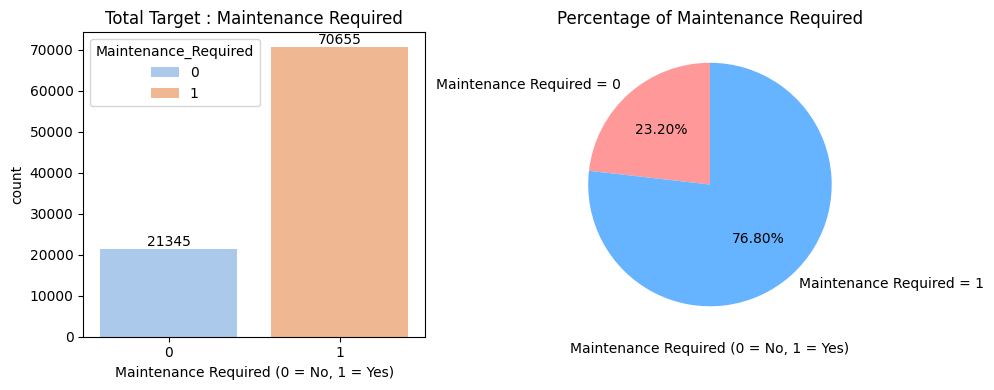

In [9]:
print('Target: Maintenance Required')
print('='*50)
print('Total fleet : ',df.shape[0])
print('Total Maintenance Required = 0 : ',df['Maintenance_Required'].value_counts()[0], '(is not recommended)')
print('Total Maintenance Required = 1 : ',df['Maintenance_Required'].value_counts()[1], '(recommended)')
print('='*50)

# Set figure
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Figur 1
sns.countplot(data=df, x='Maintenance_Required', palette='pastel', hue='Maintenance_Required', ax=ax[0])
ax[0].set_title("Total Target : Maintenance Required")
ax[0].set_xlabel('Maintenance Required (0 = No, 1 = Yes)', fontsize=10)
for container in ax[0].containers:
  ax[0].bar_label(container)


# Figur 2 - Pie
ax[1].pie([df['Maintenance_Required'].value_counts()[0],
         df['Maintenance_Required'].value_counts()[1]],
        labels=['Maintenance Required = 0','Maintenance Required = 1'],
        autopct='%1.2f%%',
        startangle=90,
        colors=['#ff9999','#66b3ff']
        )
ax[1].set_title("Percentage of Maintenance Required")
ax[1].set_xlabel('Maintenance Required (0 = No, 1 = Yes)', fontsize=10)

plt.tight_layout()
plt.show()

### Categorical Features and Maintenance Required

How is the engine condition of fleet that need to be maintained? are they different from those that don't require maintenance?

We have brake condition feature here. Since brake condition, logically, has important role in car safety, it seems like if brake condition == Poor, the vehicle have to be serviced, definitely. We will check this to make a prove.

In [10]:
filter_bad_brake = df[(df['Brake_Condition']=='Poor')]
print("Total fleet with poor brake: ", len(filter_bad_brake))

filter_bad_brake_no_service = df[(df['Brake_Condition']=='Poor') & (df['Maintenance_Required']==0)]
print("Total fleet with poor brake but doesn't need maintenance: ", len(filter_bad_brake_no_service))

filter_bad_brake_service = df[(df['Brake_Condition']=='Poor') & (df['Maintenance_Required']==1)]
print("Total fleet with poor brake and need maintenance: ", len(filter_bad_brake_service))

Total fleet with poor brake:  27613
Total fleet with poor brake but doesn't need maintenance:  0
Total fleet with poor brake and need maintenance:  27613


Insight:
* Total fleet with poor brake but doesn't need maintenance:  0
* Total fleet with poor brake and need maintenance:  27613

The result above shows to us that there is none of fleet that has brake condition == Poor but doesn't need any maintenance. This gives us a prove that poor brake condition leads to maintenance required.

Now we will see condition where the Brake Condition is Good or Fair but the fleet is recommended to be serviced or not. From here so we can learn if there is characteristic of engine's condition from required service fleet (class 1) and thoses doesn't (class 0).

In [11]:
filter_brake = df[df['Brake_Condition']!='Poor']
print("Total fleet with good/fair brake: ", len(filter_brake))

filter_brake_service = df[(df['Brake_Condition']!='Poor') & (df['Maintenance_Required']==1)]
print('Total fleet with good/fair brake but need maintenance: ', len(filter_brake_service))

filter_brake_service = df[(df['Brake_Condition']!='Poor') & (df['Maintenance_Required']==0)]
print("Total fleet with good/fair brake but doesn't need maintenance: ", len(filter_brake_service))

Total fleet with good/fair brake:  64387
Total fleet with good/fair brake but need maintenance:  43042
Total fleet with good/fair brake but doesn't need maintenance:  21345


The result above shows to us that eventhough the fleet's brake condition is good/fair, they still need to be maintained. 

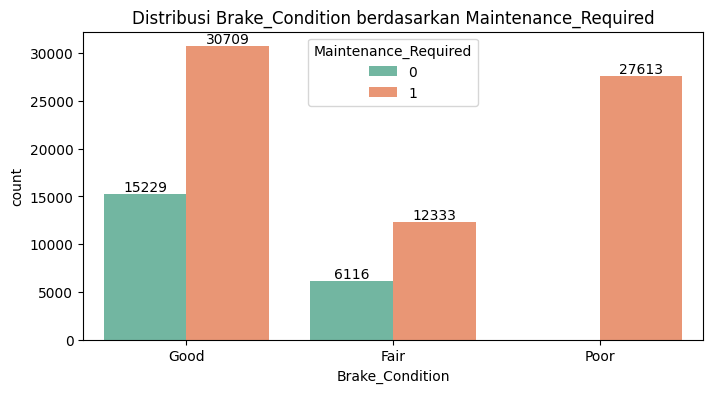

In [12]:
create_countplot('Brake_Condition', 'Maintenance_Required', df)

The above graph provides evidence that if Brake_Condition == Poor, then the fleet needs maintenance. However, this feature has two other values: Good and Fair, where fleets with Brake_Condition == Good or Fair can be recommended for maintenance or not. Therefore, Brake_Condition doesn't completely leak data.

Now we will check the features that relate to engine as follow:

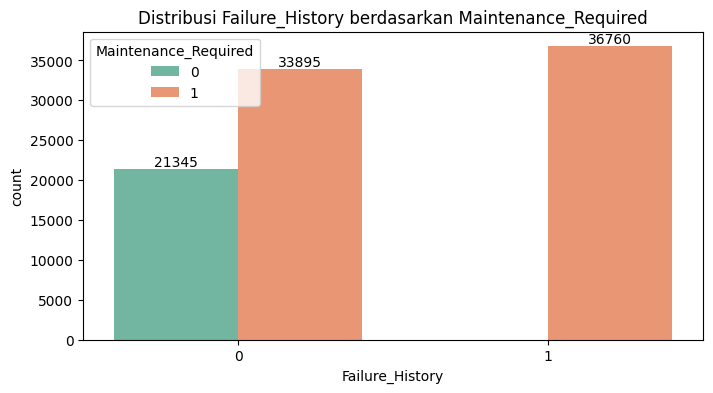

In [13]:
create_countplot('Failure_History', 'Maintenance_Required', df)

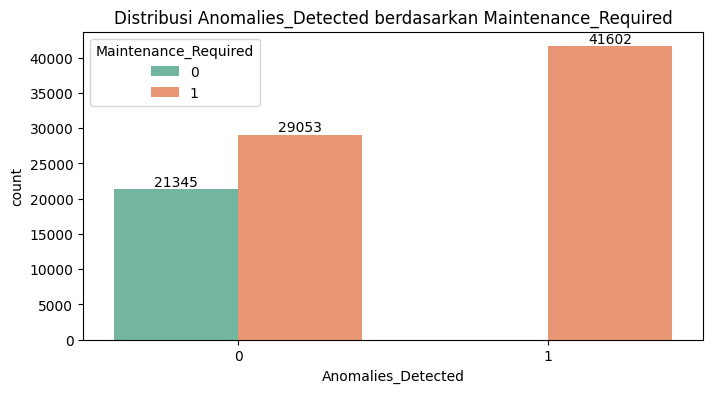

In [14]:
create_countplot('Anomalies_Detected', 'Maintenance_Required', df)

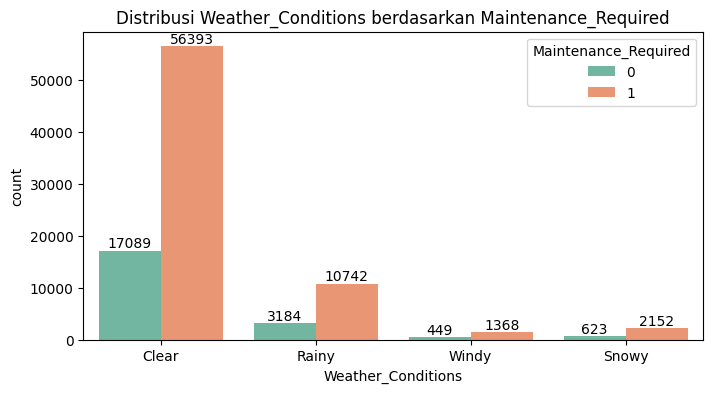

In [15]:
create_countplot('Weather_Conditions', 'Maintenance_Required', df)

### Engine Condition and Maintenance Required

In [16]:
df.columns

Index(['Vehicle_ID', 'Make_and_Model', 'Year_of_Manufacture', 'Vehicle_Type',
       'Usage_Hours', 'Route_Info', 'Load_Capacity', 'Actual_Load',
       'Last_Maintenance_Date', 'Maintenance_Type', 'Maintenance_Cost',
       'Engine_Temperature', 'Tire_Pressure', 'Fuel_Consumption',
       'Battery_Status', 'Vibration_Levels', 'Oil_Quality', 'Brake_Condition',
       'Failure_History', 'Anomalies_Detected', 'Predictive_Score',
       'Maintenance_Required', 'Weather_Conditions', 'Road_Conditions',
       'Delivery_Times', 'Downtime_Maintenance', 'Impact_on_Efficiency'],
      dtype='object')

In [17]:
print('Engine Condition - Maintenance Required Fleet:')
df[df['Maintenance_Required']==1][['Battery_Status', 'Oil_Quality', 'Tire_Pressure','Fuel_Consumption','Vibration_Levels', 'Downtime_Maintenance']].describe()

Engine Condition - Maintenance Required Fleet:


,Battery_Status,Oil_Quality,Tire_Pressure,Fuel_Consumption,Vibration_Levels,Downtime_Maintenance
count,70655.000000,70655.000000,70655.000000,70655.000000,70655.000000,70655.000000
mean,45.670555,79.902044,32.565858,10.675161,3.966228,4.180113
std,1.635825,9.818174,14.494386,5.986807,4.004459,7.055297
min,45.000000,38.303330,20.000000,5.000000,0.000405,0.000000
25%,45.000000,73.285690,20.000000,5.000000,1.122074,0.000000
50%,45.000000,80.002674,24.455649,8.388887,2.746267,0.330827
75%,45.000000,86.731791,48.858848,16.747417,5.490109,5.898303
max,50.000000,100.000000,55.000000,20.000000,44.066726,88.624732


In [18]:
print('Engine Condition - No Maintenance Required Fleet:')
df[df['Maintenance_Required']==0][['Battery_Status', 'Oil_Quality', 'Tire_Pressure','Fuel_Consumption','Vibration_Levels', 'Downtime_Maintenance']].describe()

Engine Condition - No Maintenance Required Fleet:


,Battery_Status,Oil_Quality,Tire_Pressure,Fuel_Consumption,Vibration_Levels,Downtime_Maintenance
count,21345.000000,21345.000000,21345.000000,21345.000000,21345.000000,21345.0
mean,45.667568,80.023901,32.586481,10.599012,4.015368,0.0
std,1.631289,9.714716,14.445991,5.954985,4.000776,0.0
min,45.000000,50.604292,20.000000,5.000000,0.000370,0.0
25%,45.000000,73.423877,20.000000,5.000000,1.179598,0.0
50%,45.000000,80.064324,24.780654,8.245614,2.810105,0.0
75%,45.000000,86.818322,48.621723,16.450553,5.533033,0.0
max,50.000000,100.000000,55.000000,20.000000,45.475464,0.0


From the statistics shown above, we can see that there is no significant difference between class 1 and 0. This finding confirms that there are no special characteristics of fleet conditions in class 1 and 0. 

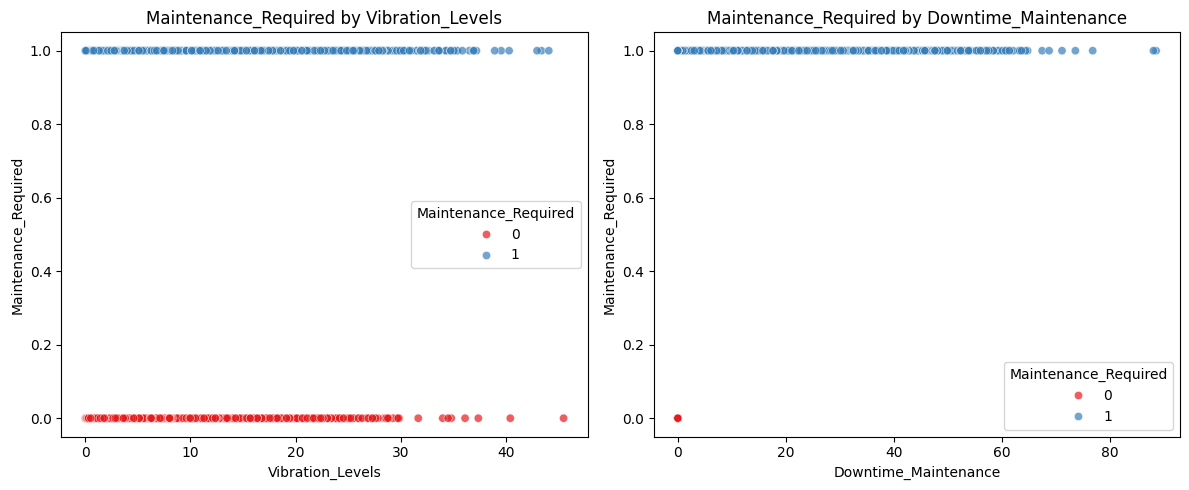

In [19]:
create_double_scatterplot(df, 'Vibration_Levels', 'Maintenance_Required', 
                          'Downtime_Maintenance', 'Maintenance_Required', 
                          'Maintenance_Required' )

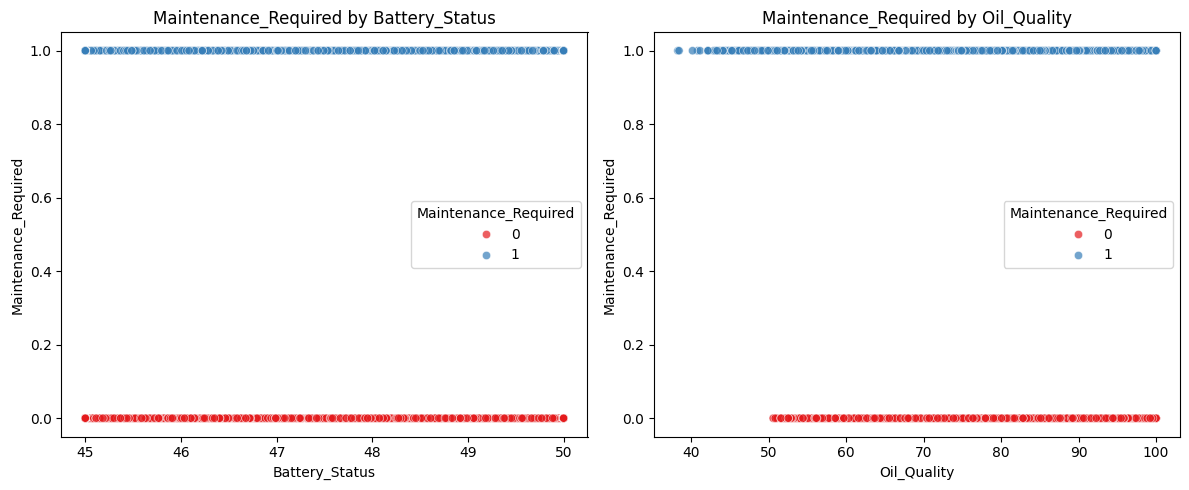

In [20]:
create_double_scatterplot(df, 'Battery_Status', 'Maintenance_Required', 
                          'Oil_Quality', 'Maintenance_Required', 
                          'Maintenance_Required' )

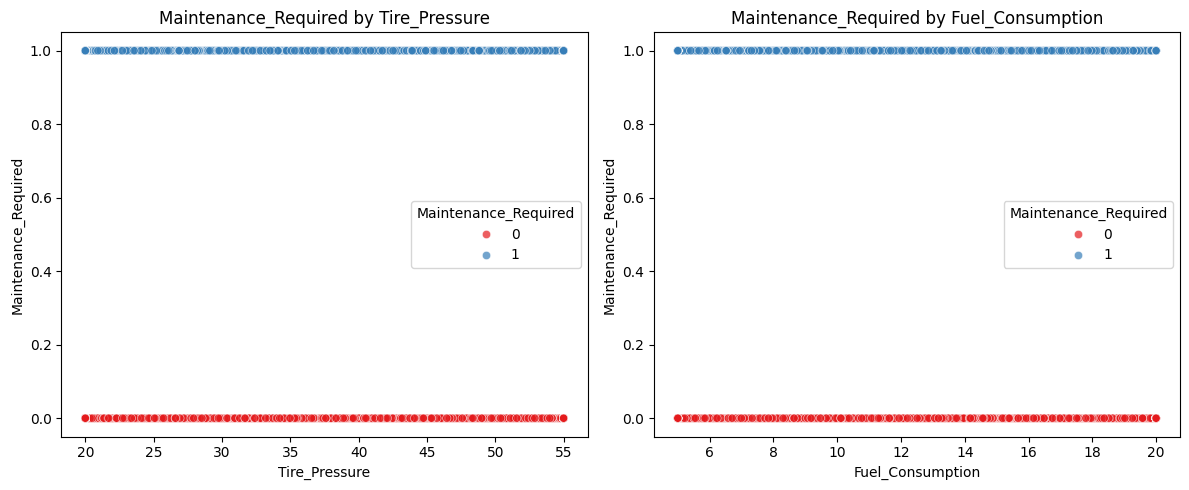

In [21]:
create_double_scatterplot(df, 'Tire_Pressure', 'Maintenance_Required', 
                          'Fuel_Consumption', 'Maintenance_Required', 
                          'Maintenance_Required' )

In [22]:
df.groupby('Maintenance_Required')['Impact_on_Efficiency'].agg(['min','mean','median','max'])

,min,mean,median,max
Maintenance_Required,,,,
0,0.1,0.206896,0.177709,0.792395
1,0.1,0.208756,0.179752,0.822859


### Find Meaning of Impact on Efficiency Feature

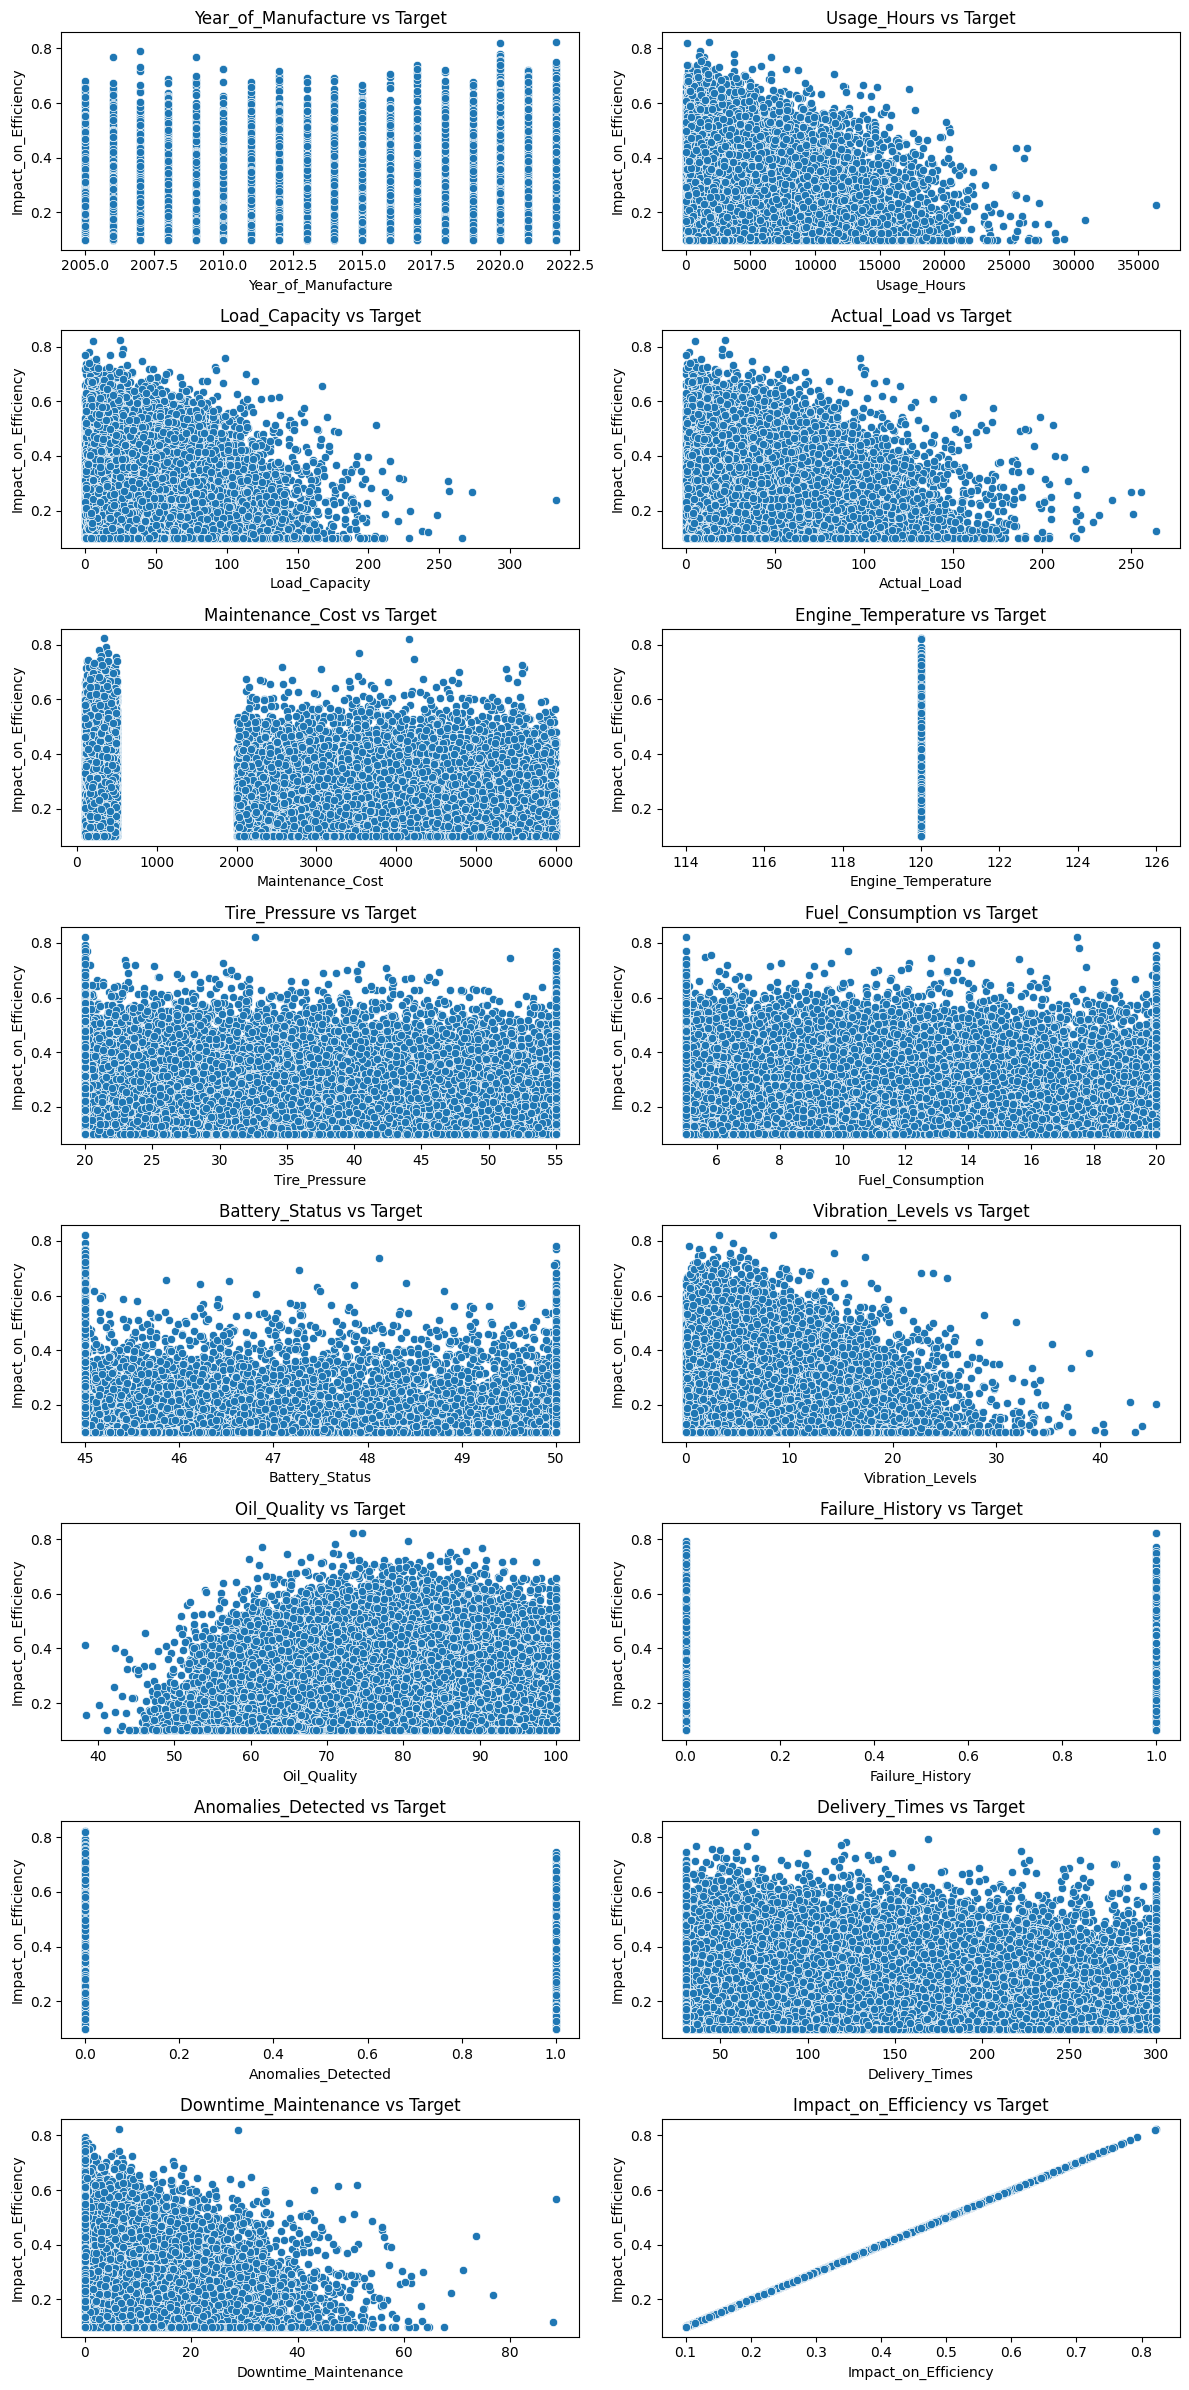

In [23]:
# Retrieve numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns=['Predictive_Score', 'Maintenance_Required', 'Vehicle_ID']).columns.tolist()

# Plot scatter for each numeric feature vs target
n_cols = 2
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows*3))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.scatterplot(x=df[col], y=df['Impact_on_Efficiency'], ax=axes[i])
    axes[i].set_title(f"{col} vs Target")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Impact_on_Efficiency")

# Remove empty axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Insight**
* `Usage_Hours`: More hours of use → higher wear and tear → maintenance is more difficult to improve efficiency → Impact_on_Efficiency tends to decrease
* `Actual_Load`: Actual load is heavier than capacity → efficiency decreases → maintenance has limited impact
* `Load_Capacity`: Vehicle is approaching capacity limit → efficiency performance is more sensitive → maintenance does not always significantly improve efficiency
* `Vibration_Levels`: High vibration indicates poor engine or structural condition → minor maintenance may not be enough to improve efficiency.
* `Downtime_Maintenance`: Long repair times → vehicle is unproductive → efficiency decreases even if maintenance is performed.

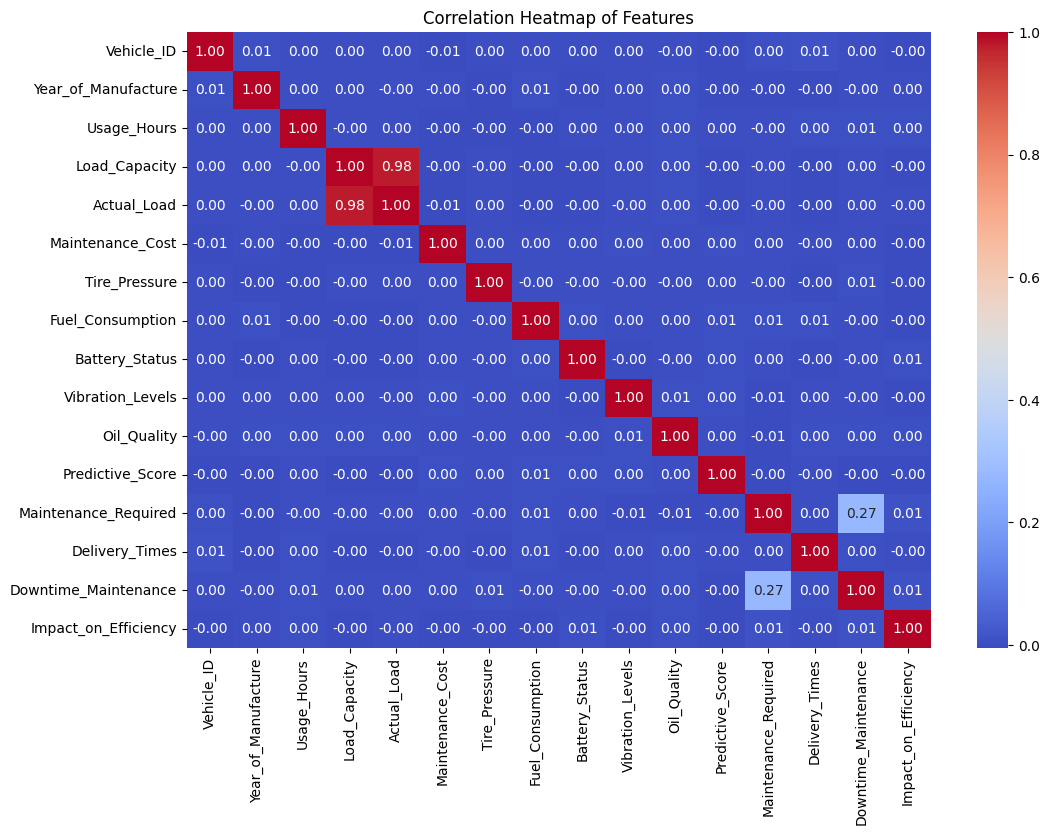

In [24]:
# Define numerical columns
# Exclude Anomalies_Detected and Failure History since they are categorical cols with integer data
num_col = df.select_dtypes(include='number').drop(columns=['Anomalies_Detected','Failure_History', 'Engine_Temperature'])

correlation_matrix = num_col.corr()
plt.figure(figsize=(12, 8)) # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

## Correlation - Kendall's Tau

In [25]:
# Calculate Kendall's Tau Correlation for each numerical cols
cols = []
p_val = []
corr_kendall = []
sig_corr = []
corr_direction = []

# Define target
target_col = 'Maintenance_Required'

for col in num_col.columns:
  if col != target_col:
    corr, p_value = stats.kendalltau(num_col[target_col], num_col[col])
    cols.append(col)
    p_val.append(p_value)
    corr_kendall.append(corr)

    if p_value < 0.05:
      sig_corr.append('Significant')
    else:
      sig_corr.append('Not Significant')

    if corr > 0:
      corr_direction.append('Positive')
    elif corr < 0:
      corr_direction.append('Negative')
    else:
      corr_direction.append('No Correlation')

# Create table
tab_corr = pd.DataFrame({
    'col':cols,
    'p_value':p_val,
    'corr_kendall':corr_kendall,
    'sig_corr':sig_corr,
    'corr_direction':corr_direction
    })

tab_corr.sort_values(by='p_value', ascending=True)

# tab_corr[tab_corr['sig_corr']=='Significant']

,col,p_value,corr_kendall,sig_corr,corr_direction
13,Downtime_Maintenance,0.000000,0.388390,Significant,Positive
9,Vibration_Levels,0.011940,-0.006767,Significant,Negative
14,Impact_on_Efficiency,0.023590,0.006219,Significant,Positive
7,Fuel_Consumption,0.109324,0.004573,Not Significant,Positive
5,Maintenance_Cost,0.182129,0.003592,Not Significant,Positive
10,Oil_Quality,0.269845,-0.002971,Not Significant,Negative
11,Predictive_Score,0.323779,-0.002656,Not Significant,Negative
1,Year_of_Manufacture,0.411511,-0.002327,Not Significant,Negative
0,Vehicle_ID,0.426980,0.002138,Not Significant,Positive
6,Tire_Pressure,0.560633,-0.001703,Not Significant,Negative


## Correlation - Chi Square

In [26]:
# Define target col
target_col = 'Maintenance_Required'

# Identifikasi kolom kategorikal
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

cat_cols.append('Anomalies_Detected')
cat_cols.append('Failure_History')

# Remove target col from cat_col if any.
if target_col in cat_cols:
    cat_cols.remove(target_col)

result = []

for col in cat_cols:
    # Cross-tabulation
    contingency_table = pd.crosstab(df[col], df[target_col])

    # Melakukan uji Chi-square
    # chi2: statistik chi-square, p: p-value
    chi2, p, dof, ex = stats.chi2_contingency(contingency_table)

    # Menentukan signifikansi
    is_significant = 'Significant' if p < 0.05 else 'Not Significant'

    # Menyimpan hasil
    result.append({
        'Feature': col,
        'Chi2_Statistic': chi2,
        'P_value': p,
        'Significance': is_significant
    })

# Membuat DataFrame dari hasil
chi2_results_df = pd.DataFrame(result)
chi2_results_df.sort_values(by='P_value', ascending=True)

,Feature,Chi2_Statistic,P_value,Significance
5,Brake_Condition,11919.457469,0.000000,Significant
8,Anomalies_Detected,22940.189299,0.000000,Significant
9,Failure_History,18493.196984,0.000000,Significant
3,Last_Maintenance_Date,603.683396,0.043851,Significant
2,Route_Info,4.173808,0.124071,Not Significant
0,Make_and_Model,5.313597,0.150223,Not Significant
6,Weather_Conditions,4.216693,0.238996,Not Significant
4,Maintenance_Type,2.168979,0.338074,Not Significant
7,Road_Conditions,1.919406,0.383007,Not Significant
1,Vehicle_Type,0.163579,0.685883,Not Significant


In [27]:
# Arah hubungan
prop_tab_brake = pd.crosstab(df['Brake_Condition'], df['Maintenance_Required'], normalize='index')*100
prop_tab_anomaly = pd.crosstab(df['Anomalies_Detected'], df['Maintenance_Required'], normalize='index')*100
prop_tab_failhist = pd.crosstab(df['Failure_History'], df['Maintenance_Required'], normalize='index')*100

print(prop_tab_brake)
print('-'*50)
print(prop_tab_anomaly)
print('-'*50)
print(prop_tab_failhist)

Maintenance_Required          0           1
Brake_Condition                            
Fair                  33.150848   66.849152
Good                  33.151204   66.848796
Poor                   0.000000  100.000000
--------------------------------------------------
Maintenance_Required          0           1
Anomalies_Detected                         
0                     42.352871   57.647129
1                      0.000000  100.000000
--------------------------------------------------
Maintenance_Required          0           1
Failure_History                            
0                     38.640478   61.359522
1                      0.000000  100.000000


**EDA Insight:**

We will drop these columns:
* Failure_History
* Anomalies_Detected
* Downtime_Maintenance,

since these columns are not a predictor or we can say they only duplicate the value of target.

# Feature Engineering

In [28]:
# Make a copy of data
data= df.copy()

## Drop Leakage Features

In [29]:
leakage_cols = ["Failure_History", "Anomalies_Detected", "Downtime_Maintenance"]
data = data.drop(columns=leakage_cols, errors="ignore")

## Normalize Features

In [30]:
# Convert to datetime
data['Last_Maintenance_Date'] = pd.to_datetime(data['Last_Maintenance_Date'])
data['Last_Maintenance_Date'].dtype

dtype('<M8[ns]')

## Feature Creation

In [31]:
# Derivative Feature
current_date = data["Last_Maintenance_Date"].max() 
data["Days_Since_Last_Maintenance"] = (current_date - data["Last_Maintenance_Date"]).dt.days

# Derivative Feature
data["Vehicle_Age"] = current_date.year - data["Year_of_Manufacture"]

In [32]:
# Drop useless columns
data= data.drop(columns=["Vehicle_ID", "Last_Maintenance_Date", 'Predictive_Score','Engine_Temperature'])

## Split Dataset

In [33]:
# Splitting X and y

y = data["Maintenance_Required"]
X = data.drop(columns=["Maintenance_Required"])
X.head()

,Make_and_Model,Year_of_Manufacture,Vehicle_Type,Usage_Hours,Route_Info,Load_Capacity,Actual_Load,Maintenance_Type,Maintenance_Cost,Tire_Pressure,...,Battery_Status,Vibration_Levels,Oil_Quality,Brake_Condition,Weather_Conditions,Road_Conditions,Delivery_Times,Impact_on_Efficiency,Days_Since_Last_Maintenance,Vehicle_Age
0,Ford F-150,2022,Truck,530,Rural,7.534549,9.004247,Oil Change,110.165442,20.0,...,45.0,2.247033,80.393803,Good,Clear,Highway,30.000000,0.150063,448,2
1,Volvo FH,2015,Van,10679,Rural,7.671728,6.111785,Tire Rotation,265.898087,20.0,...,45.0,0.851417,91.302461,Fair,Clear,Rural,30.000000,0.343017,346,9
2,Chevy Silverado,2022,Van,4181,Rural,2.901159,3.006055,Oil Change,412.483470,55.0,...,50.0,4.984557,70.109021,Good,Clear,Highway,48.627823,0.100000,471,2
3,Chevy Silverado,2011,Truck,2974,Urban,15.893347,18.825290,Tire Rotation,444.110857,20.0,...,45.0,3.000329,74.932225,Good,Clear,Highway,30.000000,0.135749,60,13
4,Ford F-150,2014,Van,2539,Rural,60.668320,65.605463,Tire Rotation,478.841922,55.0,...,50.0,3.942115,86.357250,Good,Rainy,Urban,300.000000,0.395193,228,10


In [34]:
# Split Columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

In [35]:
num_features

['Year_of_Manufacture',
 'Usage_Hours',
 'Load_Capacity',
 'Actual_Load',
 'Maintenance_Cost',
 'Tire_Pressure',
 'Fuel_Consumption',
 'Battery_Status',
 'Vibration_Levels',
 'Oil_Quality',
 'Delivery_Times',
 'Impact_on_Efficiency',
 'Days_Since_Last_Maintenance',
 'Vehicle_Age']

In [36]:
cat_features

['Make_and_Model',
 'Vehicle_Type',
 'Route_Info',
 'Maintenance_Type',
 'Brake_Condition',
 'Weather_Conditions',
 'Road_Conditions']

In [37]:
# Split train-test
# test_size = 20%, train_size = 80%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)
X_train.head()

,Make_and_Model,Year_of_Manufacture,Vehicle_Type,Usage_Hours,Route_Info,Load_Capacity,Actual_Load,Maintenance_Type,Maintenance_Cost,Tire_Pressure,...,Battery_Status,Vibration_Levels,Oil_Quality,Brake_Condition,Weather_Conditions,Road_Conditions,Delivery_Times,Impact_on_Efficiency,Days_Since_Last_Maintenance,Vehicle_Age
62113,Ford F-150,2009,Truck,2172,Rural,3.776190,3.222744,Tire Rotation,130.528233,20.000000,...,50.0,11.010426,83.953762,Good,Clear,Rural,41.057194,0.317566,181,15
4025,Tesla Semi,2022,Van,2430,Urban,6.143404,6.858280,Engine Overhaul,3347.121927,28.384529,...,45.0,3.904367,100.000000,Good,Clear,Urban,30.000000,0.100000,178,2
24921,Ford F-150,2008,Van,8054,Highway,27.569912,29.026858,Oil Change,119.962439,20.000000,...,45.0,6.591892,73.551735,Good,Clear,Rural,30.000000,0.148898,448,16
5614,Ford F-150,2014,Truck,19,Highway,9.731255,9.494420,Engine Overhaul,4612.543929,55.000000,...,45.0,0.519461,95.801599,Good,Windy,Highway,130.842738,0.170683,70,10
88880,Ford F-150,2020,Van,981,Urban,36.611459,41.124417,Tire Rotation,233.540006,53.123545,...,50.0,5.461054,85.769081,Good,Clear,Urban,36.761250,0.283238,487,4


## Handling Missing Value

We don't handle missing value since there is no NaN in the dataset and X_train.

## Handling Outliers

In [38]:
# Numerical columns to check
num_columns = X_train.select_dtypes(include='number')

listItem= []

for col in num_columns:
  listItem.append([col, round(X_train[col].skew(),1), np.where(
    (round(X_train[col].skew(),1) <= 0.5) & (round(X_train[col].skew(),1) >= -0.5),
    'normal',
    'skewed')])

skewness = pd.DataFrame(columns=['Col_Name', 'Skewness', 'Distribution'], data= listItem)
skewness.sort_values(by='Distribution')

,Col_Name,Skewness,Distribution
6,Fuel_Consumption,0.5,normal
9,Oil_Quality,-0.1,normal
12,Days_Since_Last_Maintenance,0.0,normal
0,Year_of_Manufacture,-0.9,skewed
1,Usage_Hours,2.0,skewed
2,Load_Capacity,2.0,skewed
3,Actual_Load,2.1,skewed
4,Maintenance_Cost,1.8,skewed
5,Tire_Pressure,0.6,skewed
7,Battery_Status,2.1,skewed


In [39]:
# Find upper, lower boundaries and percentage of outliers

column = []
lower_bound = []
upper_bound = []
percent_total_outlier = []

for row in range (0, len(skewness)):
  col = skewness['Col_Name'][row]
  #checking upper and lower boundary
  if skewness['Distribution'][row] == 'skewed':
    IQR = X_train[col].quantile(0.75) - X_train[col].quantile(0.25)
    lower_boundary = X_train[col].quantile(0.25) - (IQR * 3)
    upper_boundary = X_train[col].quantile(0.75) + (IQR * 3)
  else:
    lower_boundary = X_train[col].mean() - 3* X_train[col].std()
    upper_boundary = X_train[col].mean() + 3* X_train[col].std()
  #append to list
  column.append(col)
  lower_bound.append(lower_boundary)
  upper_bound.append(upper_boundary)
  totout = ((len(X_train[X_train[col] > upper_boundary]) / len(X_train) * 100) + (len(X_train[X_train[col] < lower_boundary]) / len(X_train) * 100))
  percent_total_outlier.append(totout)

outliers = pd.DataFrame({
    'column': column,
    #round the value
    'upper_boundary': [round(upper_bound,2) for upper_bound in upper_bound],
    'lower_boundary': [round(lower_bound,2) for lower_bound in lower_bound],
    'percentage_total_outliers': [round(percent_total_outlier,2) for percent_total_outlier in percent_total_outlier]
})

outliers.sort_values(by='percentage_total_outliers', ascending=False)

,column,upper_boundary,lower_boundary,percentage_total_outliers
4,Maintenance_Cost,1224.84,-523.88,20.18
7,Battery_Status,45.00,45.00,16.26
3,Actual_Load,110.53,-71.21,1.01
8,Vibration_Levels,18.53,-11.90,0.99
1,Usage_Hours,13976.00,-8977.00,0.91
2,Load_Capacity,117.17,-75.33,0.90
9,Oil_Quality,109.31,50.60,0.14
11,Impact_on_Efficiency,0.76,-0.39,0.01
0,Year_of_Manufacture,2045.00,1989.00,0.00
5,Tire_Pressure,135.31,-66.48,0.00


In [40]:
# Statistic of highest percentage total outliers
num_columns[['Maintenance_Cost','Battery_Status']].describe()

,Maintenance_Cost,Battery_Status
count,73600.000000,73600.000000
mean,1045.515012,45.669630
std,1575.198093,1.634405
min,100.002837,45.000000
25%,225.567613,45.000000
50%,349.112011,45.000000
75%,475.384871,45.000000
max,5999.625012,50.000000


We will not remove outliers because:

1. These values ​​are not data errors but rather a reflection of extreme real-world events.

2. Critical Information: This data is crucial for predicting extreme and expensive maintenance needs. Removing it would weaken the model and make it inaccurate for the most critical cases.

3. We will use a tree-based model, which is generally robust to outliers.

## Split Columns for Encoding

In [41]:
# Columns for Ordinal Encoding
ordinal_feature = ['Brake_Condition']

# Columns for One Hot Encoding
ohe_feature = ['Maintenance_Type', 'Route_Info', 'Weather_Conditions',
           'Road_Conditions', 'Vehicle_Type', 'Make_and_Model']


brake_condition_order=[['Poor', 'Fair', 'Good']]

## Feature Selection

In [42]:
# Calculate Kendall's Tau Correlation for each numerical cols
cols = []
p_val = []
corr_kendall = []
sig_corr = []
corr_direction = []

target_col = 'Maintenance_Required'

for col in num_features:
  if col != target_col:
    corr, p_value = stats.kendalltau(X_train[col], y_train)
    cols.append(col)
    p_val.append(p_value)
    corr_kendall.append(corr)

    if p_value < 0.05:
      sig_corr.append('Significant')
    else:
      sig_corr.append('Not Significant')

    if corr > 0:
      corr_direction.append('Positive')
    elif corr < 0:
      corr_direction.append('Negative')
    else:
      corr_direction.append('No Correlation')

# Create table
tab_corr = pd.DataFrame({
    'col':cols,
    'p_value':p_val,
    'corr_kendall':corr_kendall,
    'sig_corr':sig_corr,
    'corr_direction':corr_direction
    })

tab_corr.sort_values(by='p_value', ascending=True)

,col,p_value,corr_kendall,sig_corr,corr_direction
8,Vibration_Levels,0.017255,-0.007167,Significant,Negative
11,Impact_on_Efficiency,0.084061,0.005307,Not Significant,Positive
6,Fuel_Consumption,0.121172,0.004948,Not Significant,Positive
4,Maintenance_Cost,0.147353,0.004361,Not Significant,Positive
2,Load_Capacity,0.160538,-0.004223,Not Significant,Negative
3,Actual_Load,0.187319,-0.003968,Not Significant,Negative
12,Days_Since_Last_Maintenance,0.389253,-0.002594,Not Significant,Negative
0,Year_of_Manufacture,0.425931,-0.002522,Not Significant,Negative
13,Vehicle_Age,0.425931,0.002522,Not Significant,Positive
7,Battery_Status,0.457246,-0.002679,Not Significant,Negative


In [43]:
# Calculate Chi Stats for categorical
result = []

for col in cat_features:
    # Cross-tabulation
    contingency_table = pd.crosstab(X_train[col], y_train)

    # Melakukan uji Chi-square
    # chi2: statistik chi-square, p: p-value
    chi2, p, dof, ex = stats.chi2_contingency(contingency_table)

    # Menentukan signifikansi
    is_significant = 'Significant' if p < 0.05 else 'Not Significant'

    # Menyimpan hasil
    result.append({
        'Feature': col,
        'Chi2_Statistic': chi2,
        'P_value': p,
        'Significance': is_significant
    })

# Membuat DataFrame dari hasil
chi2_results_df = pd.DataFrame(result)
chi2_results_df.sort_values(by='P_value', ascending=True)

,Feature,Chi2_Statistic,P_value,Significance
4,Brake_Condition,9620.209764,0.000000,Significant
2,Route_Info,6.394293,0.040879,Significant
0,Make_and_Model,6.076123,0.107965,Not Significant
3,Maintenance_Type,2.612071,0.270892,Not Significant
6,Road_Conditions,2.294328,0.317536,Not Significant
5,Weather_Conditions,1.794870,0.616052,Not Significant
1,Vehicle_Type,0.011632,0.914114,Not Significant


We will keep all the columns with consideration that all columns are related to logistic and transportation.

# Pipeline - Encoding

In [44]:
# Pipeline OHE
ohe_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Pipeline Ordinal Encoding
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(categories=brake_condition_order))
])

# Pipeline Numerical Features
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Preprocessor Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('ohe_feature', ohe_pipeline, ohe_feature),
    ('ordinal_feature', ordinal_pipeline, ordinal_feature),
    ('numerical_feature', numerical_pipeline, num_features)
], remainder='passthrough') # keep the non encoding features

# Pipeline - Model

In [45]:
categorical_indices = [
    X_train.columns.get_loc(col) for col in cat_features
]
categorical_indices

[0, 2, 4, 7, 14, 15, 16]

In [46]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73600 entries, 62113 to 76399
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Make_and_Model               73600 non-null  object 
 1   Year_of_Manufacture          73600 non-null  int64  
 2   Vehicle_Type                 73600 non-null  object 
 3   Usage_Hours                  73600 non-null  int64  
 4   Route_Info                   73600 non-null  object 
 5   Load_Capacity                73600 non-null  float64
 6   Actual_Load                  73600 non-null  float64
 7   Maintenance_Type             73600 non-null  object 
 8   Maintenance_Cost             73600 non-null  float64
 9   Tire_Pressure                73600 non-null  float64
 10  Fuel_Consumption             73600 non-null  float64
 11  Battery_Status               73600 non-null  float64
 12  Vibration_Levels             73600 non-null  float64
 13  Oil_Quality      

In [47]:
# Pipeline Decision Tree
pipeline_dt = ImbPipeline(steps=[
    ('smote', SMOTENC(random_state=42, categorical_features=categorical_indices)),
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Pipeline Random Forest
pipeline_rf = ImbPipeline(steps=[
    ('smote', SMOTENC(random_state=42, categorical_features=categorical_indices)),
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Pipeline XGBoost
pipeline_xgb = ImbPipeline(steps=[
    ('smote', SMOTENC(random_state=42, categorical_features=categorical_indices)),
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

# Model Training

In [48]:
# Training Model Decision Tree
pipeline_dt.fit(X_train, y_train)

c:\Users\User\miniconda3\envs\h8_env\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\User\miniconda3\envs\h8_env\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Pipeline(steps=[('smote',
                 SMOTENC(categorical_features=[0, 2, 4, 7, 14, 15, 16],
                         random_state=42)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_feature',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Maintenance_Type',
                                                   'Route_Info',
                                                   'Weather_...
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Year_of_Manufacture',
                                                   'Usage_Hours',
                                                   'Load_Capacity',
                                                   'Actual_Load',
                                                   'Maintenance_Cost',
                                                   'Tire_Pressure',
                                                   'Fuel_Consumption',
                                                   'Battery_Status',
                                                   'Vibration_Levels',
                                                   'Oil_Quality',
                                                   'Delivery_Times',
                                                   'Impact_on_Efficiency',
                                                   'Days_Since_Last_Maintenance',
                                                   'Vehicle_Age'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [49]:
# Training Model Random Forest
pipeline_rf.fit(X_train, y_train)

c:\Users\User\miniconda3\envs\h8_env\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\User\miniconda3\envs\h8_env\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Pipeline(steps=[('smote',
                 SMOTENC(categorical_features=[0, 2, 4, 7, 14, 15, 16],
                         random_state=42)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_feature',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Maintenance_Type',
                                                   'Route_Info',
                                                   'Weather_...
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Year_of_Manufacture',
                                                   'Usage_Hours',
                                                   'Load_Capacity',
                                                   'Actual_Load',
                                                   'Maintenance_Cost',
                                                   'Tire_Pressure',
                                                   'Fuel_Consumption',
                                                   'Battery_Status',
                                                   'Vibration_Levels',
                                                   'Oil_Quality',
                                                   'Delivery_Times',
                                                   'Impact_on_Efficiency',
                                                   'Days_Since_Last_Maintenance',
                                                   'Vehicle_Age'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [50]:
# Training Model XGBoost
pipeline_xgb.fit(X_train, y_train)

c:\Users\User\miniconda3\envs\h8_env\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\User\miniconda3\envs\h8_env\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Pipeline(steps=[('smote',
                 SMOTENC(categorical_features=[0, 2, 4, 7, 14, 15, 16],
                         random_state=42)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_feature',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Maintenance_Type',
                                                   'Route_Info',
                                                   'Weather_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

# Model Evaluation

In [51]:
# Buat Looping untuk Cross Validation Score
models = [
    ("Decision Tree Classifier", pipeline_dt),
    ("Random Forest Classifier", pipeline_rf),
    ("XGBoost Classifier", pipeline_xgb)
]

f1_all = []
f1_mean = []
f1_std = []
f1_range = []

for name, model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)

    f1_all.append(scores)
    f1_mean.append(scores.mean())
    f1_std.append(scores.std())
    f1_range.append(f"{scores.mean()-scores.std():.4f} - {scores.mean()+scores.std():.4f}")

cross_val_score_df = pd.DataFrame({
    'Model': [name for name, _ in models],
    'F1 Score - All': f1_all,
    'F1 Score - Mean': f1_mean,
    'F1 Score - Std': f1_std,
    'F1 Score - Range of Test-Set': f1_range
})

cross_val_score_df

,Model,F1 Score - All,F1 Score - Mean,F1 Score - Std,F1 Score - Range of Test-Set
0,Decision Tree Classifier,"[0.7784228571428572, 0.7858571168878385, 0.781...",0.782014,0.003123,0.7789 - 0.7851
1,Random Forest Classifier,"[0.8110004330879168, 0.8069399262632835, 0.809...",0.809380,0.001587,0.8078 - 0.8110
2,XGBoost Classifier,"[0.8356136072417641, 0.8338573556180705, 0.833...",0.833365,0.001421,0.8319 - 0.8348


XGBoost performed best, with the highest F1 Score - Mean and the lowest F1 Score - Standard Deviation.

XGBoost is better suited for large datasets, can be tuned faster, and is generally better at generalizing.

Therefore, in this case, we will check whether the model has high recall or not.

In [52]:
# Predict
pred_base_train = pipeline_xgb.predict(X_train)
pred_base_test = pipeline_xgb.predict(X_test)

# Evaluation Report
class_report_train_1 = classification_report(y_train, pred_base_train)
class_report_test_1 = classification_report(y_test, pred_base_test)

print('Model SVM (Not Tuned):')
print('*'*60)
print('Classification Report/n')
print('Report - Train:')
print(class_report_train_1)
print('-'*60)
print('Report - Test:')
print(class_report_test_1)

Model SVM (Not Tuned):
************************************************************
Classification Report/n
Report - Train:
              precision    recall  f1-score   support

           0       0.63      0.34      0.44     17135
           1       0.82      0.94      0.88     56465

    accuracy                           0.80     73600
   macro avg       0.73      0.64      0.66     73600
weighted avg       0.78      0.80      0.78     73600

------------------------------------------------------------
Report - Test:
              precision    recall  f1-score   support

           0       0.33      0.18      0.23      4210
           1       0.79      0.89      0.84     14190

    accuracy                           0.73     18400
   macro avg       0.56      0.54      0.53     18400
weighted avg       0.68      0.73      0.70     18400



# Hyperparameter Tuning

We will improve the model with Hyperparameter Tuning.

## Best Model

In [53]:
# Hyperparameter tuning for XGBoost
param_dist_xgb = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__scale_pos_weight': [1, np.sum(y_train==0)/np.sum(y_train==1)]  # for imbalance
}

random_search_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_distributions=param_dist_xgb,
    n_iter=20,
    scoring='recall',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search_xgb.fit(X_train, y_train)
print("Best params XGBoost:", random_search_xgb.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\User\miniconda3\envs\h8_env\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\User\miniconda3\envs\h8_env\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Best params XGBoost: {'classifier__subsample': 1.0, 'classifier__scale_pos_weight': 1, 'classifier__n_estimators': 500, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 1.0}


In [54]:
# Evaluation for Tuned XGBoost
y_pred_train_xgb = random_search_xgb.predict(X_train)
y_pred_test_xgb = random_search_xgb.predict(X_test)

print("Classification Report for Tuned XGBoost")
print("\nXGBoost - Train Report:\n", classification_report(y_train, y_pred_train_xgb))
print("\nXGBoost - Test Report:\n", classification_report(y_test, y_pred_test_xgb))

Classification Report for Tuned XGBoost

XGBoost - Train Report:
               precision    recall  f1-score   support

           0       0.75      0.37      0.50     17135
           1       0.83      0.96      0.89     56465

    accuracy                           0.82     73600
   macro avg       0.79      0.67      0.69     73600
weighted avg       0.81      0.82      0.80     73600


XGBoost - Test Report:
               precision    recall  f1-score   support

           0       0.34      0.15      0.20      4210
           1       0.78      0.92      0.84     14190

    accuracy                           0.74     18400
   macro avg       0.56      0.53      0.52     18400
weighted avg       0.68      0.74      0.70     18400



In [55]:
# Best tuned pipeline
best_tuned_pipeline = random_search_xgb.best_estimator_

                                    Feature  Importance
13         ordinal_feature__Brake_Condition    0.627187
27           numerical_feature__Vehicle_Age    0.073766
14   numerical_feature__Year_of_Manufacture    0.059002
21        numerical_feature__Battery_Status    0.032708
4     ohe_feature__Weather_Conditions_Rainy    0.030701
19         numerical_feature__Tire_Pressure    0.026664
20      numerical_feature__Fuel_Consumption    0.025965
5     ohe_feature__Weather_Conditions_Snowy    0.016373
25  numerical_feature__Impact_on_Efficiency    0.008998
6     ohe_feature__Weather_Conditions_Windy    0.008479
12     ohe_feature__Make_and_Model_Volvo FH    0.008460
10   ohe_feature__Make_and_Model_Ford F-150    0.006975
24        numerical_feature__Delivery_Times    0.006659
2             ohe_feature__Route_Info_Rural    0.006513
11   ohe_feature__Make_and_Model_Tesla Semi    0.006210


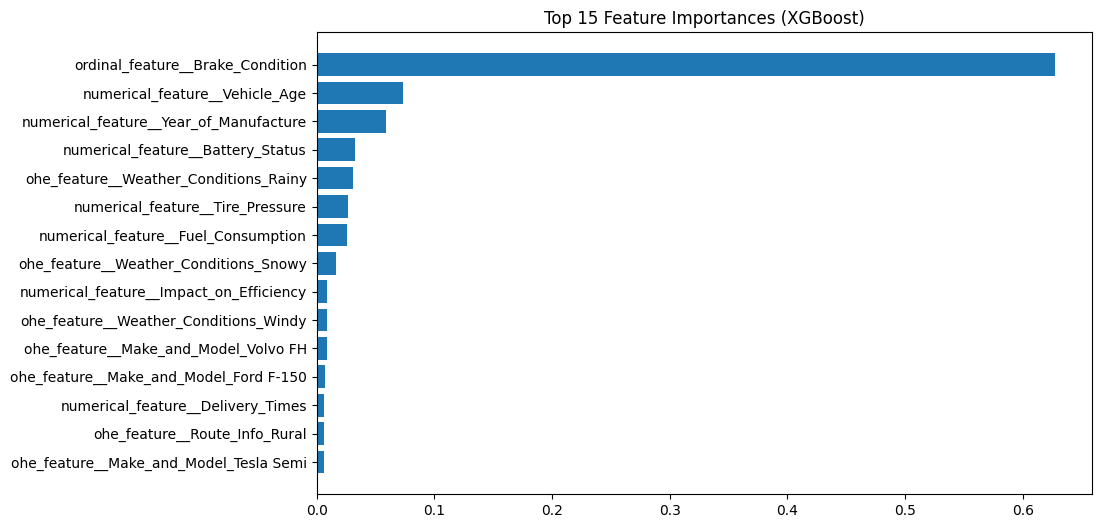

In [56]:
# Take out model XGB from pipeline
xgb_model = best_tuned_pipeline.named_steps['classifier']

# Find feature after preprocessor transformer
feature_names = best_tuned_pipeline.named_steps['preprocessor'].get_feature_names_out()


# Find importance from model
importances = xgb_model.feature_importances_

# Create dataframe for feature importance
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

print(feat_imp.head(15))  # show top 15 feature

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_imp['Feature'][:15], feat_imp['Importance'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()

It appears that `Brake_Condition` is the most important feature, and this makes logical sense in the logistics industry, especially regarding fleet safety. Logistics fleets are large and carry a higher safety responsibility on the road. Therefore, even if the engine is in good condition, if the braking condition is poor, it must be repaired.

# Model Saving

In [57]:
# Save GridSearch + pipeline
joblib.dump(best_tuned_pipeline, 'best_model_classification.pkl')

['best_model_classification.pkl']